# 長程-建立模型-最低價格_log

In [2]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

# 讀取數據，指定「停留城市」為字串
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/long_flight_final.csv'
dtype_spec = {"停留城市": str}
data = pd.read_csv(file_path, dtype=dtype_spec)

# One-hot encoding：針對多個分類欄位進行處理
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '機場分類', '航空公司組合', '航空聯盟', '停靠站數量', '是否過夜',
                    '是否為平日', '機型分類', '假期', 'Region', '飛行時間兩段分類', '艙等（主航段）']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化
num_cols = ['停留時間_分鐘', '飛行時間_分鐘', 'Cost of Living Index',
            'GDP (PPP) per capita (in thousand USD)', 'competing_flights']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# 選取建模特徵：先挑選 dummy 欄位，再加上數值型特徵
target_keywords = ['出發時段_', '抵達時段_', '航空公司組合_', '航空聯盟_', '停靠站數量_', 
                   '機型分類_', '是否為平日_', '假期_', 'Region_', '機場分類_', 
                   '飛行時間兩段分類_', '艙等（主航段）_']
dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]
feature_cols = dummy_cols + ['停留時間_分鐘', '飛行時間_分鐘', 'Cost of Living Index', 
                             'GDP (PPP) per capita (in thousand USD)', 'competing_flights']

# 定義自變數與目標變數
X = data[feature_cols]
y = data["最低價格_log"]

# 定義單次運行的函數，針對一個隨機種子進行資料分割、模型訓練與評估
def run_model(seed):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    n_test = len(y_test)
    p = X.shape[1]
    
    result = {}
    
    # 隨機森林
    rf_model = RandomForestRegressor(n_estimators=200, random_state=seed, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    adjusted_r_rf = 1 - (1 - r2_rf) * (n_test - 1) / (n_test - p - 1)
    result['RandomForest'] = {'MSE': mse_rf, 'R2': r2_rf, 'RMSE': rmse_rf, 'Adjusted_R2': adjusted_r_rf}
    
    # XGBoost
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, 
                             random_state=seed, n_jobs=-1)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    adjusted_r_xgb = 1 - (1 - r2_xgb) * (n_test - 1) / (n_test - p - 1)
    result['XGBoost'] = {'MSE': mse_xgb, 'R2': r2_xgb, 'RMSE': rmse_xgb, 'Adjusted_R2': adjusted_r_xgb}
    
    # SVR
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr_model.fit(X_train, y_train)
    y_pred_svr = svr_model.predict(X_test)
    mse_svr = mean_squared_error(y_test, y_pred_svr)
    r2_svr = r2_score(y_test, y_pred_svr)
    rmse_svr = np.sqrt(mse_svr)
    adjusted_r_svr = 1 - (1 - r2_svr) * (n_test - 1) / (n_test - p - 1)
    result['SVR'] = {'MSE': mse_svr, 'R2': r2_svr, 'RMSE': rmse_svr, 'Adjusted_R2': adjusted_r_svr}
    
    return result

# 設定要運行的隨機種子數量
seeds = [123, 234, 345, 456, 567]

# 平行化運算每個隨機種子下的結果
all_results = Parallel(n_jobs=-1)(delayed(run_model)(seed) for seed in seeds)

# 整理三個模型各自的結果
results = {
    'RandomForest': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
    'XGBoost': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
    'SVR': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []}
}

for res in all_results:
    for model in results.keys():
        results[model]['MSE'].append(res[model]['MSE'])
        results[model]['R2'].append(res[model]['R2'])
        results[model]['RMSE'].append(res[model]['RMSE'])
        results[model]['Adjusted_R2'].append(res[model]['Adjusted_R2'])

# 計算各模型的平均結果
avg_results = {}
for model, metrics in results.items():
    avg_results[model] = {
        'Average MSE': np.mean(metrics['MSE']),
        'Average R2': np.mean(metrics['R2']),
        'Average RMSE': np.mean(metrics['RMSE']),
        'Average Adjusted_R2': np.mean(metrics['Adjusted_R2'])
    }

# 顯示結果
print("Average Performance over {} runs:".format(len(seeds)))
for model, scores in avg_results.items():
    print(f"{model}:")
    print(f"  MSE = {scores['Average MSE']:.4f}")
    print(f"  R^2 = {scores['Average R2']:.4f}")
    print(f"  RMSE = {scores['Average RMSE']:.4f}")
    print(f"  Adjusted R^2 = {scores['Average Adjusted_R2']:.4f}")

Average Performance over 5 runs:
RandomForest:
  MSE = 0.0245
  R^2 = 0.9613
  RMSE = 0.1566
  Adjusted R^2 = 0.9612
XGBoost:
  MSE = 0.0405
  R^2 = 0.9361
  RMSE = 0.2012
  Adjusted R^2 = 0.9360
SVR:
  MSE = 0.0439
  R^2 = 0.9308
  RMSE = 0.2094
  Adjusted R^2 = 0.9307


**30次平均**

In [5]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
import gc

# 讀取數據，指定「停留城市」為字串
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/long_flight_final.csv'
dtype_spec = {"停留城市": str}
data = pd.read_csv(file_path, dtype=dtype_spec)

# One-hot encoding：針對多個分類欄位進行處理
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '機場分類', '航空公司組合', '航空聯盟', '停靠站數量', '是否過夜',
                    '是否為平日', '機型分類', '假期', 'Region', '飛行時間兩段分類', '艙等（主航段）']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化
num_cols = ['停留時間_分鐘', '飛行時間_分鐘', 'Cost of Living Index',
            'GDP (PPP) per capita (in thousand USD)', 'competing_flights']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# 選取建模特徵
target_keywords = ['出發時段_', '抵達時段_', '航空公司組合_', '航空聯盟_', '停靠站數量_', 
                   '機型分類_', '是否為平日_', '假期_', 'Region_', '機場分類_', 
                   '飛行時間兩段分類_', '艙等（主航段）_']
dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]
feature_cols = dummy_cols + ['停留時間_分鐘', '飛行時間_分鐘', 'Cost of Living Index', 
                             'GDP (PPP) per capita (in thousand USD)', 'competing_flights']

# 定義自變數與目標變數
X = data[feature_cols]
y = data["最低價格_log"]

# 定義單次運行的函數，針對一個隨機種子進行資料分割、模型訓練與評估
def run_model(seed):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    n_test = len(y_test)
    p = X.shape[1]
    
    result = {}
    
    # 隨機森林
    rf_model = RandomForestRegressor(n_estimators=200, random_state=seed, n_jobs=2)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    adjusted_r_rf = 1 - (1 - r2_rf) * (n_test - 1) / (n_test - p - 1)
    result['RandomForest'] = {'MSE': mse_rf, 'R2': r2_rf, 'RMSE': rmse_rf, 'Adjusted_R2': adjusted_r_rf}
    
    # XGBoost
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, 
                             random_state=seed, n_jobs=2, tree_method='hist')
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    adjusted_r_xgb = 1 - (1 - r2_xgb) * (n_test - 1) / (n_test - p - 1)
    result['XGBoost'] = {'MSE': mse_xgb, 'R2': r2_xgb, 'RMSE': rmse_xgb, 'Adjusted_R2': adjusted_r_xgb}
    
    # SVR
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr_model.fit(X_train, y_train)
    y_pred_svr = svr_model.predict(X_test)
    mse_svr = mean_squared_error(y_test, y_pred_svr)
    r2_svr = r2_score(y_test, y_pred_svr)
    rmse_svr = np.sqrt(mse_svr)
    adjusted_r_svr = 1 - (1 - r2_svr) * (n_test - 1) / (n_test - p - 1)
    result['SVR'] = {'MSE': mse_svr, 'R2': r2_svr, 'RMSE': rmse_svr, 'Adjusted_R2': adjusted_r_svr}
    
    # 每次任務結束後嘗試釋放記憶體
    gc.collect()
    return result

# 定義運行次數與隨機種子列表
n_runs = 30
seeds = list(range(n_runs))

# 平行化運算，設定 timeout 為 300 秒（根據需要可調整），並降低 n_jobs
all_results = Parallel(n_jobs=2)(delayed(run_model)(seed) for seed in seeds)

# 整理三個模型各自的結果
results = {
    'RandomForest': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
    'XGBoost': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
    'SVR': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []}
}

for res in all_results:
    for model in results.keys():
        results[model]['MSE'].append(res[model]['MSE'])
        results[model]['R2'].append(res[model]['R2'])
        results[model]['RMSE'].append(res[model]['RMSE'])
        results[model]['Adjusted_R2'].append(res[model]['Adjusted_R2'])

# 計算各模型的平均結果
avg_results = {}
for model, metrics in results.items():
    avg_results[model] = {
        'Average MSE': np.mean(metrics['MSE']),
        'Average R2': np.mean(metrics['R2']),
        'Average RMSE': np.mean(metrics['RMSE']),
        'Average Adjusted_R2': np.mean(metrics['Adjusted_R2'])
    }

# 顯示結果
print("Average Performance over {} runs:".format(len(seeds)))
for model, scores in avg_results.items():
    print(f"{model}:")
    print(f"  MSE = {scores['Average MSE']:.4f}")
    print(f"  R^2 = {scores['Average R2']:.4f}")
    print(f"  RMSE = {scores['Average RMSE']:.4f}")
    print(f"  Adjusted R^2 = {scores['Average Adjusted_R2']:.4f}")

Average Performance over 30 runs:
RandomForest:
  MSE = 0.0245
  R^2 = 0.9614
  RMSE = 0.1564
  Adjusted R^2 = 0.9614
XGBoost:
  MSE = 0.0404
  R^2 = 0.9364
  RMSE = 0.2009
  Adjusted R^2 = 0.9363
SVR:
  MSE = 0.0441
  R^2 = 0.9305
  RMSE = 0.2099
  Adjusted R^2 = 0.9304


**視覺化**

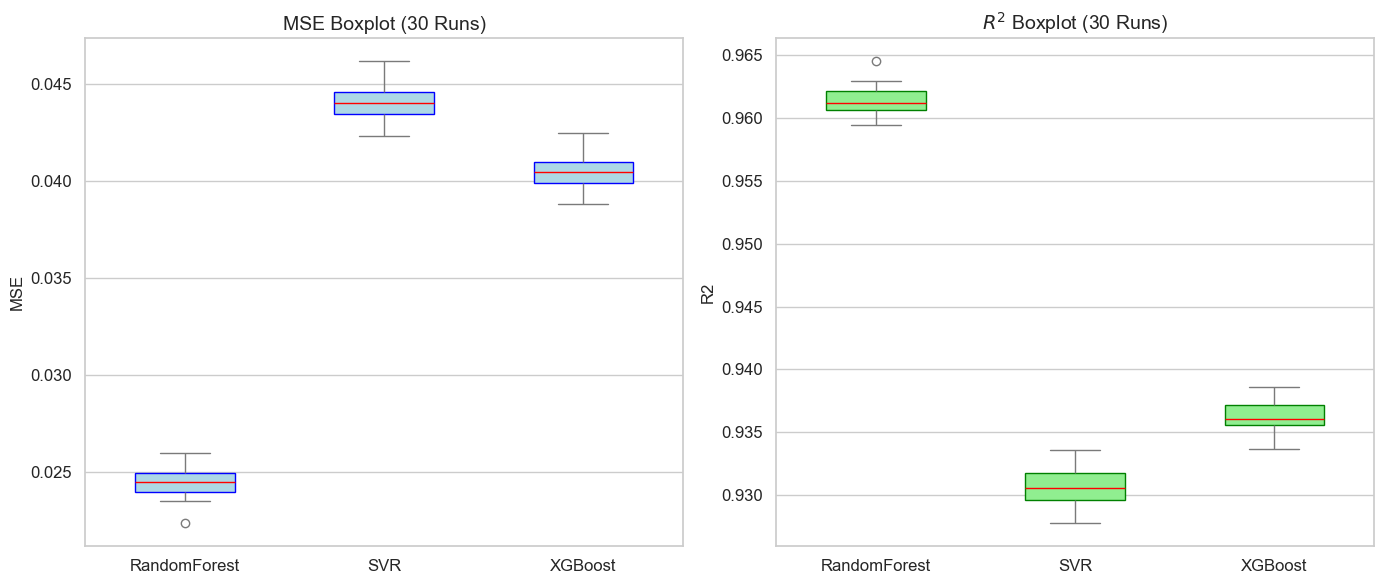

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 假設 results 字典已包含各模型 30 次的結果
# 轉換資料格式
mse_df = pd.DataFrame({
    'RandomForest': results['RandomForest']['MSE'],
    'SVR': results['SVR']['MSE'],
    'XGBoost': results['XGBoost']['MSE']
})
r2_df = pd.DataFrame({
    'RandomForest': results['RandomForest']['R2'],
    'SVR': results['SVR']['R2'],
    'XGBoost': results['XGBoost']['R2']
})

# 使用 melt 將資料轉為長格式 (long-form)
mse_long = mse_df.melt(var_name='Model', value_name='MSE')
r2_long = r2_df.melt(var_name='Model', value_name='R2')

# 設定 Seaborn 主題
sns.set(style='whitegrid', palette='pastel')

# 建立圖形
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# MSE 盒鬚圖
sns.boxplot(x='Model', y='MSE', data=mse_long, ax=axes[0],
            width=0.5, showfliers=True, 
            boxprops={'facecolor':'lightblue', 'edgecolor':'blue'},
            medianprops={'color': 'red'})
axes[0].set_title('MSE Boxplot (30 Runs)', fontsize=14)
axes[0].set_xlabel('')
axes[0].tick_params(labelsize=12)

# R^2 盒鬚圖
sns.boxplot(x='Model', y='R2', data=r2_long, ax=axes[1],
            width=0.5, showfliers=True,
            boxprops={'facecolor':'lightgreen', 'edgecolor':'green'},
            medianprops={'color': 'red'})
axes[1].set_title('$R^2$ Boxplot (30 Runs)', fontsize=14)
axes[1].set_xlabel('')
axes[1].tick_params(labelsize=12)

plt.tight_layout()
plt.show()

In [ ]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import gc

# 1. 讀取數據，指定「停留城市」為字串
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/long_flight_final.csv'
dtype_spec = {"停留城市": str}
data = pd.read_csv(file_path, dtype=dtype_spec)

# 若你的資料有日期欄位，請確認資料已依日期排序，範例如下：
data['出發日期'] = pd.to_datetime(data['出發日期'])
data.sort_values(by='出發日期', inplace=True)

# 2. One-hot encoding：針對多個分類欄位進行處理
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '機場分類', '航空公司組合', '航空聯盟', '停靠站數量', '是否過夜',
                    '是否為平日', '機型分類', '假期', 'Region', '飛行時間兩段分類', '艙等（主航段）']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 3. 數值型特徵標準化
num_cols = ['停留時間_分鐘', '飛行時間_分鐘', 'Cost of Living Index',
            'GDP (PPP) per capita (in thousand USD)', 'competing_flights']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# 4. 選取建模特徵
target_keywords = ['出發時段_', '抵達時段_', '航空公司組合_', '航空聯盟_', '停靠站數量_', 
                   '機型分類_', '是否為平日_', '假期_', 'Region_', '機場分類_', 
                   '飛行時間兩段分類_', '艙等（主航段）_']
dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]
feature_cols = dummy_cols + ['停留時間_分鐘', '飛行時間_分鐘', 'Cost of Living Index', 
                             'GDP (PPP) per capita (in thousand USD)', 'competing_flights']

# 5. 定義自變數與目標變數
X = data[feature_cols]
y = data["最低價格_log"]

# 6. 根據日期先後劃分資料
# 假設資料是依日期從舊到新排序，前70%作為訓練集，後30%作為測試集
split_index = int(0.7 * len(data))
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

X_train = train_data[feature_cols]
y_train = train_data["最低價格_log"]
X_test = test_data[feature_cols]
y_test = test_data["最低價格_log"]

# 7. 重新訓練最終模型（以隨機森林為例）
final_rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=2)
final_rf_model.fit(X_train, y_train)

# 8. 評估模型表現（選擇性步驟）
y_pred_rf = final_rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
n_test = len(y_test)
p = X.shape[1]
adjusted_r_rf = 1 - (1 - r2_rf) * (n_test - 1) / (n_test - p - 1)
print("Random Forest 在測試集上的表現：")
print(f"MSE: {mse_rf:.4f}")
print(f"R^2: {r2_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"Adjusted R^2: {adjusted_r_rf:.4f}")

# 9. 儲存訓練好的模型
dump(final_rf_model, 'minprice_rf_long.joblib')
print("隨機森林模型已儲存為 'minprice_rf_long.joblib'.")

# 10. 載入模型並進行預測（範例）

# 讀入excel as new data
new_data = pd.read_excel('/Users/yuchingchen/Documents/專題/cleaned_data/data/long/sydney.csv')

# 確保 new_data 只保留用來預測的特徵欄位
new_data_features = new_data[feature_cols]

# 載入先前儲存好的模型（例如 minprice_rf_long.joblib）
loaded_model = load('minprice_rf_long.joblib')

# 進行預測
predictions_log = loaded_model.predict(new_data_features)

# 如果「最低價格_log」為對數轉換後的結果，則反轉換回原始價格
predictions = np.exp(predictions_log)
